# Bay Area Bike Share Analysis

## Introduction

[Bay Area Bike Share](http://www.bayareabikeshare.com/) is a company that provides on-demand bike rentals for customers in San Francisco, Redwood City, Palo Alto, Mountain View, and San Jose. Users can unlock bikes from a variety of stations throughout each city, and return them to any station within the same city. Users pay for the service either through a yearly subscription or by purchasing 3-day or 24-hour passes. Users can make an unlimited number of trips, with trips under thirty minutes in length having no additional charge; longer trips will incur overtime fees.


After inspecting the data and reading the help file (READ_ME.txt) we conclude that the data was collected from the bike management system. This data allows us to see the information of what, when, where, and how the bike share system was implemented in Bay Area. The key information is about the number of bike, docks, and the transitions/ trips among stations. 

>**The available variables**: in this data are listed below
- station_id (type: numeric)
- bikes_avaibility (type: integer)
- docks_avaibility (type: integer)
- time (type: date&time)
- name of station (type: string/character)
- lat: latitude (type: float)
- long: longitude (type: float)
- dockcount: number of total docks at station (type: integer)
- landmark: city (San Francisco, Redwood City, Palo Alto, Mountain View, San Jose) (type: string/character)
- installation date that station was installed (type: date&time)
- Trip ID: numeric ID of bike trip (type: numeric) 
- Duration: time of trip in seconds (type: numeric)
- Start Date: start date of trip with date and time, in PST (type: date&time)
- Start Station: station name of start station (type: date&time)
- Start Terminal: numeric reference for start station (type: numeric)
- End Date: end date of trip with date and time, in PST (type: date&time)
- End Station: station name for end station (type: date&time)
- End Terminal: numeric reference for end station (type: numeric)
- Bike #: ID of bike used (type: numeric)
- Subscription Type: Subscriber = annual member; Customer = 24-hour or 3-day member (type: string/character)
- Zip Code: Home zip code of user (only available for annual members) (type: numeric)
- Max_Visibility_Miles (type: numberic)
- Mean_Visibility_Miles (type: numberic)
- Min_Visibility_Miles (type: numberic)
- Precipitation_In (type: numberic)
- Cloud_Cover (type: numberic)
- Events (type: string)
- zip code: 94107=San Francisco, 94063=Redwood City, 94301=Palo Alto, 94041=Mountain View, 95113= San Jose (type: numeric)

Looking at a summary of the data, we see that most variables are numeric data types, name of station, landmark, subscription type are character types.

With the huge investment in bikes, docks and the management system, the questions of effectivity of the system will be asked. This data can answer some of those questions: 

> ** Is there effect from weather to people's bike usage? **

> ** Where and when do people in 5 cities have high potential to use shared bike? **


## Data Wrangling

Year 1 and Year 2 data are downloaded from the Bay Area Bike Share's [Open Data](http://www.bayareabikeshare.com/open-data) 

The data comes in three parts: 
- the first half of Year 1 (files starting `201402`), 
- the second half of Year 1 (files starting `201408`), 
- and all of Year 2 (files starting `201508`). 

There are three main datafiles associated with each part: trip data showing information about each trip taken in the system (`*_trip_data.csv`), information about the stations in the system (`*_station_data.csv`), and daily weather data for each city in the system (`*_weather_data.csv`).

When dealing with a lot of data, it can be useful to start by working with only a sample of the data. This way, it will be much easier to check that our data wrangling steps are working since our code will take less time to complete. Once we are satisfied with the way things are working, we can then set things up to work on the dataset as a whole.

Since the bulk of the data is contained in the trip information, we should target looking at a subset of the trip data to help us get our bearings. I'll start by looking at only the first month of the bike trip data, from 2013-08-29 to 2013-09-30. The code below will take the data from the first half of the first year, then write the first month's worth of data to an output file. This code exploits the fact that the data is sorted by date (though it should be noted that the first two days are sorted by trip time, rather than being completely chronological).



In [3]:
# import all necessary packages and functions.
import csv
from datetime import datetime
import numpy as np
import pandas as pd
from babs_datacheck import question_3
from babs_visualizations import usage_stats, usage_plot
from IPython.display import display
%matplotlib inline

In [4]:
# file locations
file_in  = 'data/201402_trip_data.csv'
file_out = 'data/201309_trip_data.csv'

with open(file_out, 'w') as f_out, open(file_in, 'r') as f_in:
    # set up csv reader and writer objects
    in_reader = csv.reader(f_in)
    out_writer = csv.writer(f_out)

    # write rows from in-file to out-file until specified date reached
    while True:
        datarow = next(in_reader)
        # trip start dates in 3rd column, m/d/yyyy HH:MM formats
        if datarow[2][:9] == '10/1/2013':
            break
        out_writer.writerow(datarow)

### Condensing the Trip Data

The first step is to look at the structure of the dataset to see if there's any data wrangling we should perform. The below cell will read in the sampled data file that you created in the previous cell, and print out the first few rows of the table.

In [6]:
sample_data = pd.read_csv('data/201309_trip_data.csv')

display(sample_data.head())

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscription Type,Zip Code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In this exploration, we're going to concentrate on factors in the trip data that affect the number of trips that are taken. Let's focus down on a few selected columns: the trip duration, start time, start terminal, end terminal, and subscription type. Start time will be divided into year, month, and hour components. We will also add a column for the day of the week and abstract the start and end terminal to be the start and end _city_.

Let's tackle the lattermost part of the wrangling process first. Run the below code cell to see how the station information is structured, then observe how the code will create the station-city mapping. Note that the station mapping is set up as a function, `create_station_mapping()`. Since it is possible that more stations are added or dropped over time, this function will allow us to combine the station information across all three parts of our data when we are ready to explore everything.

In [8]:
# Display the first few rows of the station data file.
station_info = pd.read_csv('data/201402_station_data.csv')
display(station_info.head())

# This function will be called by another function later on to create the mapping.
def create_station_mapping(station_data):
    """
    Create a mapping from station IDs to cities, returning the
    result as a dictionary.
    """
    station_map = {}
    for data_file in station_data:
        with open(data_file, 'r') as f_in:
            # set up csv reader object - note that we are using DictReader, which
            # takes the first row of the file as a header row for each row's
            # dictionary keys
            weather_reader = csv.DictReader(f_in)

            for row in weather_reader:
                station_map[row['station_id']] = row['landmark']
    return station_map

,station_id,name,lat,long,dockcount,landmark,installation
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [11]:
def summarise_data(trip_in, station_data, trip_out):
    """
    This function takes trip and station information and outputs a new
    data file with a condensed summary of major trip information. The
    trip_in and station_data arguments will be lists of data files for
    the trip and station information, respectively, while trip_out
    specifies the location to which the summarized data will be written.
    """
    # generate dictionary of station - city mapping
    station_map = create_station_mapping(station_data)
    
    with open(trip_out, 'w') as f_out:
        # set up csv writer object        
        out_colnames = ['duration', 'start_date', 'start_year',
                        'start_month', 'start_hour', 'weekday',
                        'start_city', 'end_city', 'subscription_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        for data_file in trip_in:
            with open(data_file, 'r') as f_in:
                # set up csv reader object
                trip_reader = csv.DictReader(f_in)

                # collect data from and process each row
                for row in trip_reader:
                    new_point = {}
                    
                    # convert duration units from seconds to minutes
                    ### Question 3a: Add a mathematical operation below   ###
                    ### to convert durations from seconds to minutes.     ###
                    new_point['duration'] = float(row['Duration'])/60
                    
                    # reformat datestrings into multiple columns
                    ### Question 3b: Fill in the blanks below to generate ###
                    ### the expected time values.                         ###
                    trip_date = datetime.strptime(row['Start Date'], '%m/%d/%Y %H:%M')
                    new_point['start_date']  = trip_date.strftime('%Y-%m-%d')
                    new_point['start_year']  = trip_date.strftime('%Y')
                    new_point['start_month'] = trip_date.strftime('%m')
                    new_point['start_hour']  = trip_date.strftime('%H')
                    new_point['weekday']     = trip_date.strftime('%A')
                    
                    # remap start and end terminal with start and end city
                    new_point['start_city'] = station_map[row['Start Terminal']]
                    new_point['end_city'] = station_map[row['End Terminal']]
                    # two different column names for subscribers depending on file
                    if 'Subscription Type' in row:
                        new_point['subscription_type'] = row['Subscription Type']
                    else:
                        new_point['subscription_type'] = row['Subscriber Type']

                    # write the processed information to the output file.
                    trip_writer.writerow(new_point)

In [12]:
# Process the data by running the function we wrote above.
station_data = ['data/201402_station_data.csv']
trip_in = ['data/201309_trip_data.csv']
trip_out = 'data/201309_trip_summary.csv'
summarise_data(trip_in, station_data, trip_out)

# Load in the data file and print out the first few rows
sample_data = pd.read_csv(trip_out)
display(sample_data.head())

# Verify the dataframe by counting data points matching each of the time features.
question_3(sample_data)

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,Thursday,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,Thursday,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,Thursday,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,Thursday,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,Thursday,San Francisco,San Francisco,Subscriber


All counts are as expected!


## Exploratory Data Analysis

Now that you have some data saved to a file, let's look at some initial trends in the data. 
I use some code which has already been written in the `babs_visualizations.py` script by other to help summarize and visualize the data; this has been imported as the functions `usage_stats()` and `usage_plot()`. 


In [14]:
trip_data = pd.read_csv('data/201309_trip_summary.csv')

usage_stats(trip_data)

There are 27345 data points in the dataset.
The average duration of trips is 27.60 minutes.
The median trip duration is 10.72 minutes.
25% of trips are shorter than 6.82 minutes.
25% of trips are longer than 17.28 minutes.


array([  6.81666667,  10.71666667,  17.28333333])

It can be seen that there are over 27,000 trips in the first month, and that the average trip duration is larger than the median trip duration (the point where 50% of trips are shorter, and 50% are longer). In fact, the mean is larger than the 75% shortest durations. This will be interesting to look at later on.

Let's start looking at how those trips are divided by subscription type. One easy way to build an intuition about the data is to plot it.

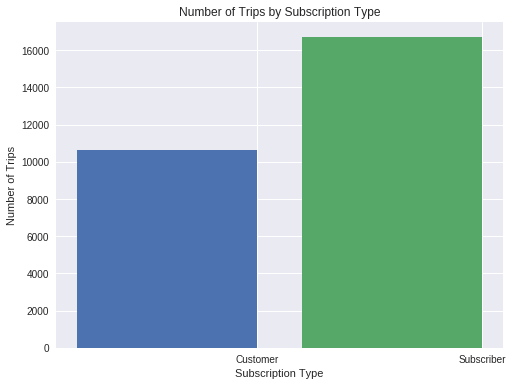

In [15]:
usage_plot(trip_data, 'subscription_type')

Seems like there's about 50% more trips made by subscribers in the first month than customers. Let's try a different variable now. What does the distribution of trip durations look like?

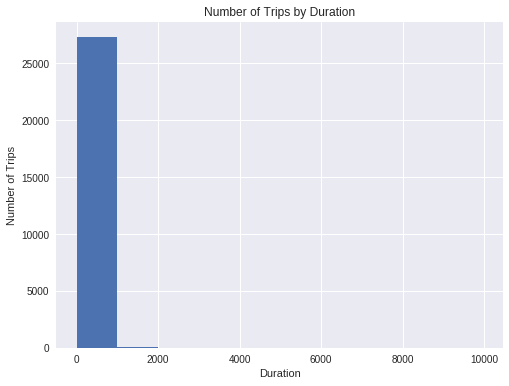

In [16]:
usage_plot(trip_data, 'duration')

Looks pretty strange, doesn't it? Take a look at the duration values on the x-axis. Most rides are expected to be 30 minutes or less, since there are overage charges for taking extra time in a single trip. The first bar spans durations up to about 1000 minutes, or over 16 hours. Based on the statistics we got out of `usage_stats()`, we should have expected some trips with very long durations that bring the average to be so much higher than the median: the plot shows this in a dramatic, but unhelpful way.

When exploring the data, you will often need to work with visualization function parameters in order to make the data easier to understand. Here's where the third argument of the `usage_plot()` function comes in. Filters can be set for data points as a list of conditions. Let's start by limiting things to trips of less than 60 minutes.

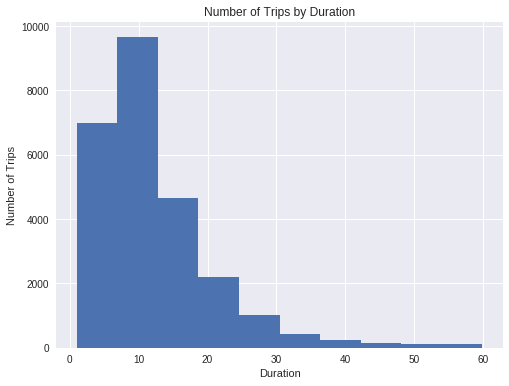

In [17]:
usage_plot(trip_data, 'duration', ['duration < 60'])

This is looking better! It can be seen that most trips are indeed less than 30 minutes in length, but there's more that you can do to improve the presentation. Since the minimum duration is not 0, the left hand bar is slighly above 0. We want to be able to tell where there is a clear boundary at 30 minutes, so it will look nicer if we have bin sizes and bin boundaries that correspond to some number of minutes. Fortunately, you can use the optional "boundary" and "bin_width" parameters to adjust the plot. By setting "boundary" to 0, one of the bin edges (in this case the left-most bin) will start at 0 rather than the minimum trip duration. And by setting "bin_width" to 5, each bar will count up data points in five-minute intervals.

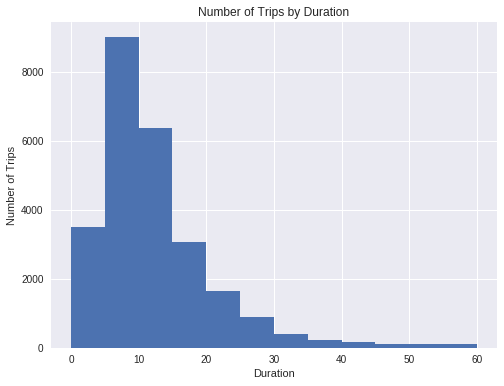

In [18]:
usage_plot(trip_data, 'duration', ['duration < 60'], boundary = 0, bin_width = 5)

 The second five-minute trip duration (trip of 5-10 minutes) shows the most number of trips. That's around 9100 trips


## Performing some other Analysis

Now that it has been done with some exploration on a small sample of the dataset, it's time to go ahead and put together all of the data in a single file and see what trends you can find. The code below will use the same `summarise_data()` function as before to process data. 


In [20]:
station_data = ['data/201402_station_data.csv',
                'data/201408_station_data.csv',
                'data/201508_station_data.csv' ]
trip_in = ['data/201402_trip_data.csv',
           'data/201408_trip_data.csv',
           'data/201508_trip_data.csv' ]
trip_out = 'babs_y1_y2_summary.csv'

# This function will take in the station data and trip data and
# write out a new data file to the name listed above in trip_out.
summarise_data(trip_in, station_data, trip_out)

Since the `summarise_data()` function has created a standalone file, the above cell will not need to be run a second time, even if you close the notebook and start a new session. You can just load in the dataset and then explore things from there.

In [21]:
trip_data = pd.read_csv('babs_y1_y2_summary.csv')
display(trip_data.head())

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,Thursday,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,Thursday,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,Thursday,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,Thursday,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,Thursday,San Francisco,San Francisco,Subscriber


In [30]:
usage_stats(trip_data)

There are 669959 data points in the dataset.
The average duration of trips is 18.47 minutes.
The median trip duration is 8.62 minutes.
25% of trips are shorter than 5.73 minutes.
25% of trips are longer than 12.58 minutes.


array([  5.73333333,   8.61666667,  12.58333333])

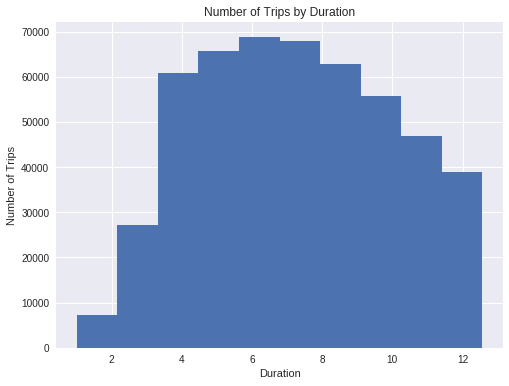

In [105]:
usage_plot(trip_data, 'duration', ['duration <= 12.58'] )

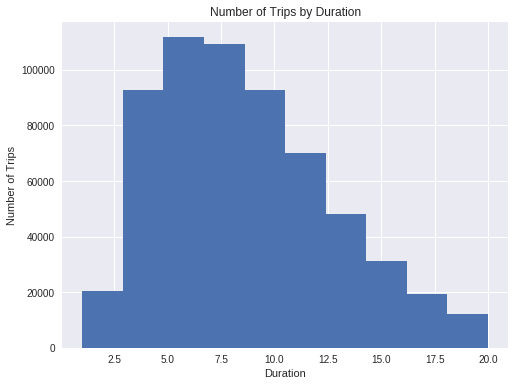

In [52]:
usage_plot(trip_data, 'duration', ['duration <= 20'])

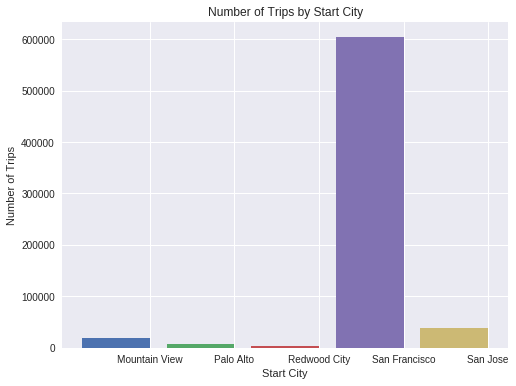

In [109]:
usage_plot(trip_data, 'start_city')

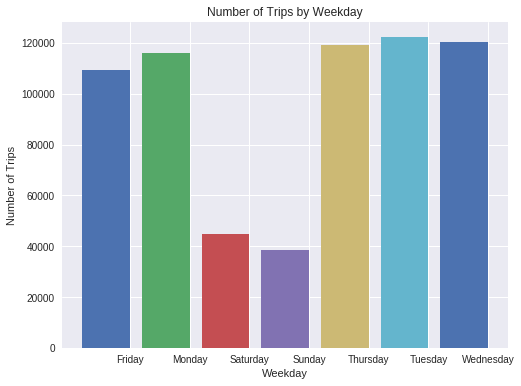

In [112]:
usage_plot(trip_data, 'weekday')

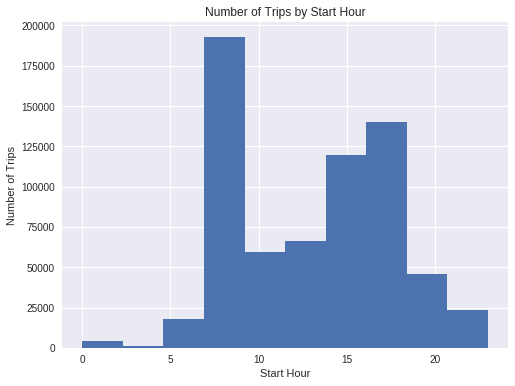

In [114]:
usage_plot(trip_data, 'start_hour')

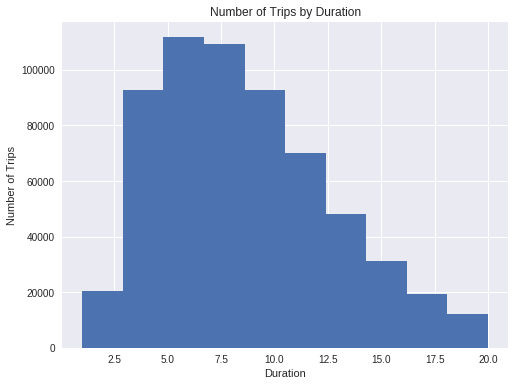

In [106]:
# Final Plot 1
usage_plot(trip_data, 'duration', ['duration <= 20'])

Because of the average of duration is 18.75 minutes, and only 25% of the trips are longer than 12.5 minutes, so the data points are further than 20 minutes can be considered outlines. To have meaningful histogram, I set the conditions of duration <=20.

From this visualization, We can conclude that most of the biking trips is in the short distances which only take from around 3 to 10 minutes to travel. So we can imply that people prefer riding bike when they commute among close locations.

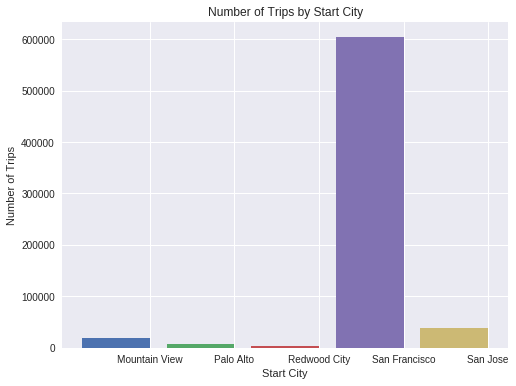

In [115]:
# Final Plot 2
usage_plot(trip_data, 'start_city')

The bike share system was installed in 5 cities, however from the chart, we can see that only San Francisco utilized this system. The number of trips in San Francisco were over 600,000; more than 12 times higher than the second city - San Jose with less than 40000 trips. 
This visualization answers the question of where people use bike shared system the most. In other words, it recommends the city in which the bike shared system should be implemented. 

## Conclusions

Many questions can be answered basing on exploring the data we have. And data analysis plays a role of making sense data and information to stakeholders. 

My next project, I would like to apply data analysis techniques in Real estate problems where the trend of market movement and the housing price can be explained by data analysis tools. Furthermore, I want to predict housing market price and bid-winning price using data-driven reasons.  
